In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.8.1


In [3]:
print('Available devices:', tf.config.list_physical_devices())

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3*1024)]
#     )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2022-11-16 17:49:09.974977: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-16 17:49:09.975018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: beldroega-Inspiron-7572
2022-11-16 17:49:09.975028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: beldroega-Inspiron-7572
2022-11-16 17:49:09.975119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-11-16 17:49:09.975140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-11-16 17:49:09.975145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3


In [4]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
COLOR_MODE='grayscale'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , seed=123
)

Found 5481 files belonging to 8 classes.


2022-11-16 17:49:10.152271: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
nlabels = 8*[0]
images = {}
for _images, _labels in dataset:
    for image, label in zip(_images, _labels):
        label = int(label)
        nlabels[label] += 1  
        if ( label in images ):
            images[label].append(image)
        else:
            images[label] = []
            images[label].append(image)
class_names = dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in _labels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
2            7            5            4            6            4            5            7            4           


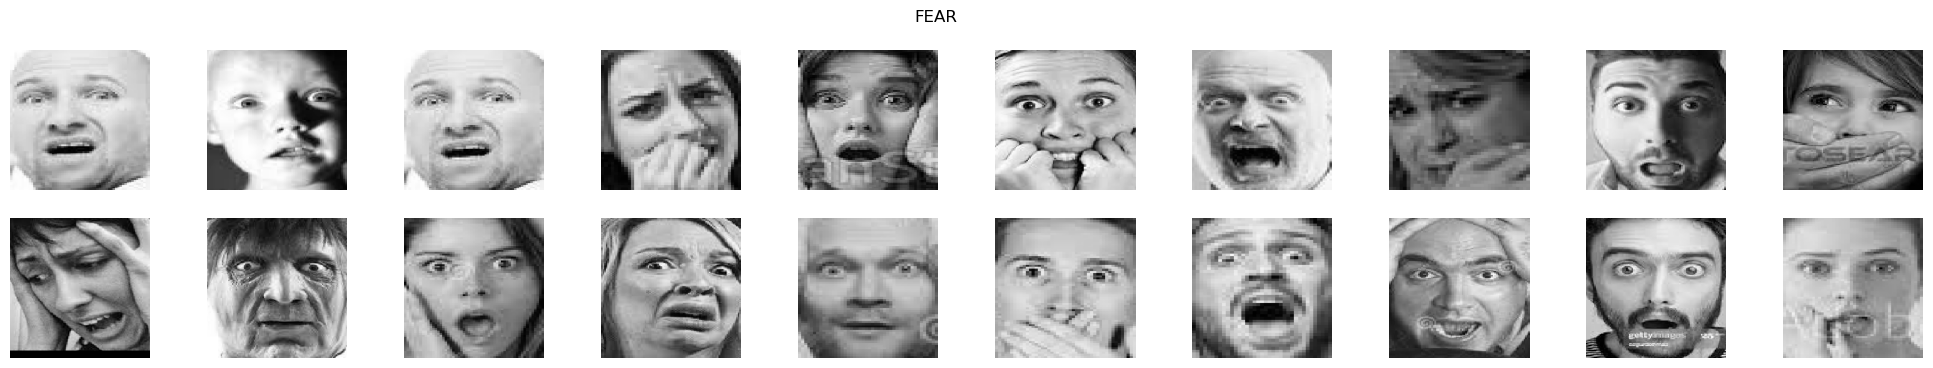

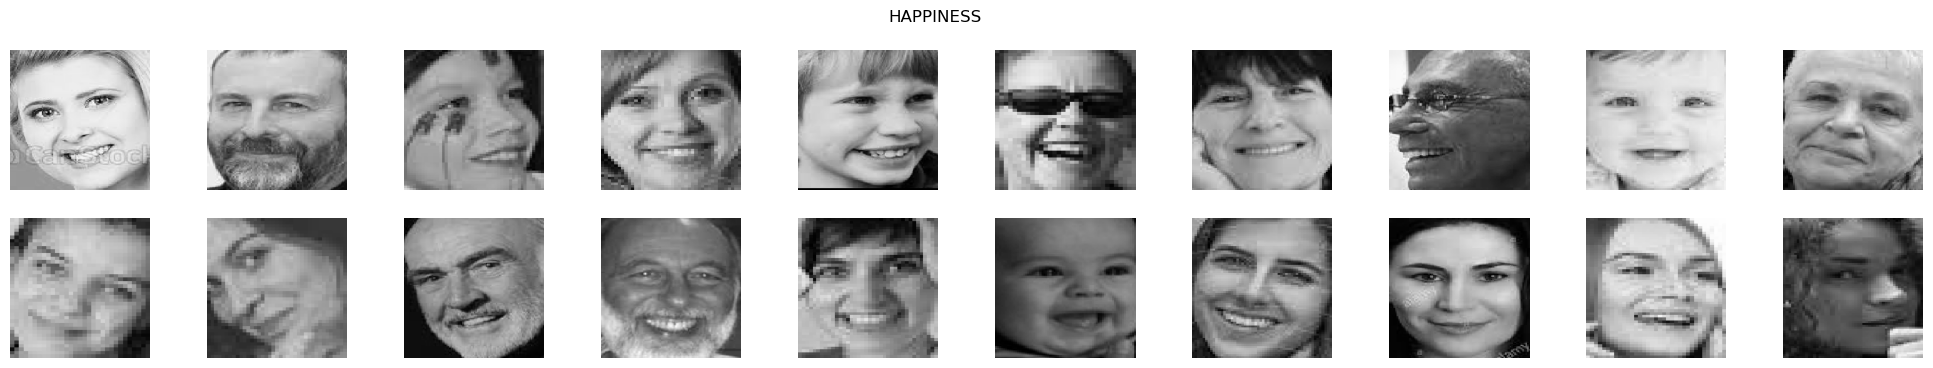

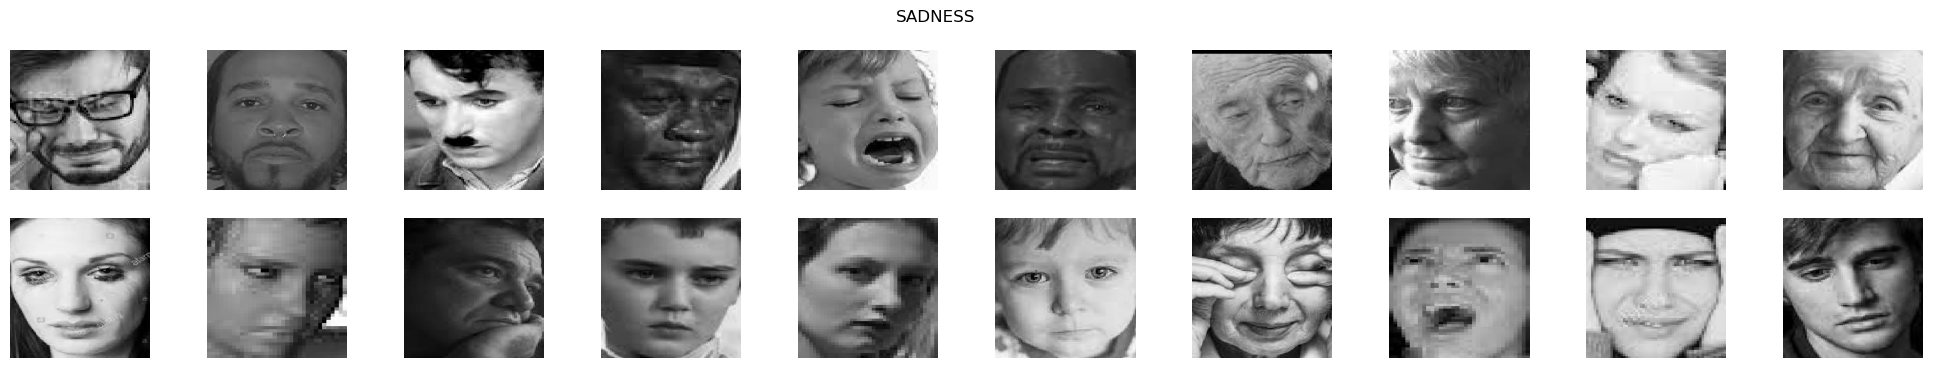

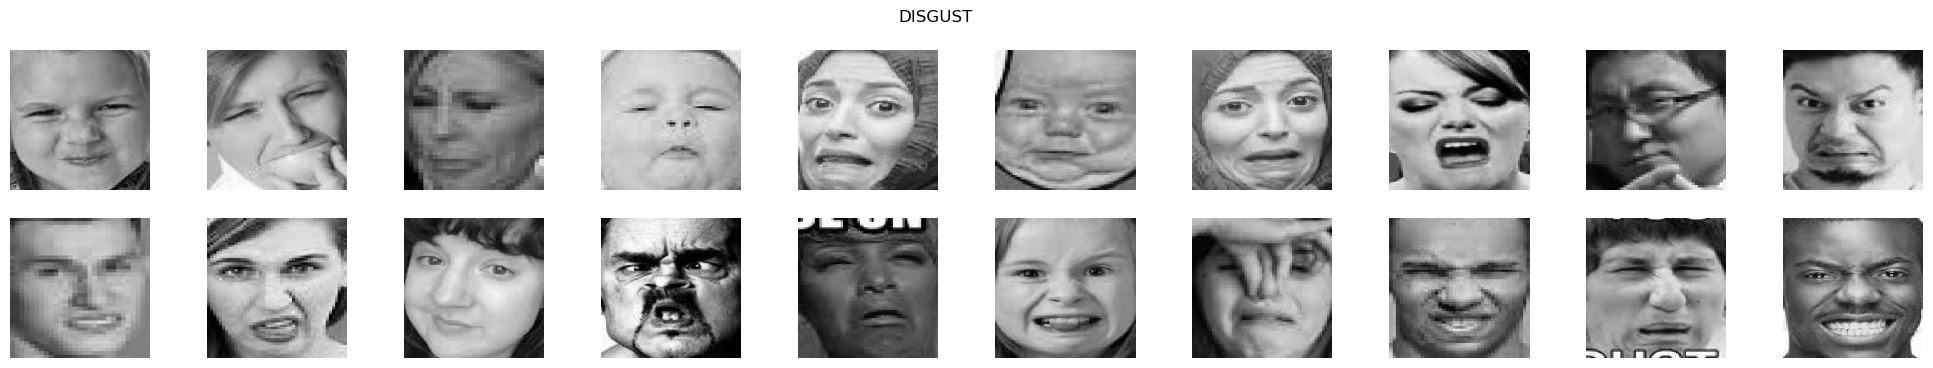

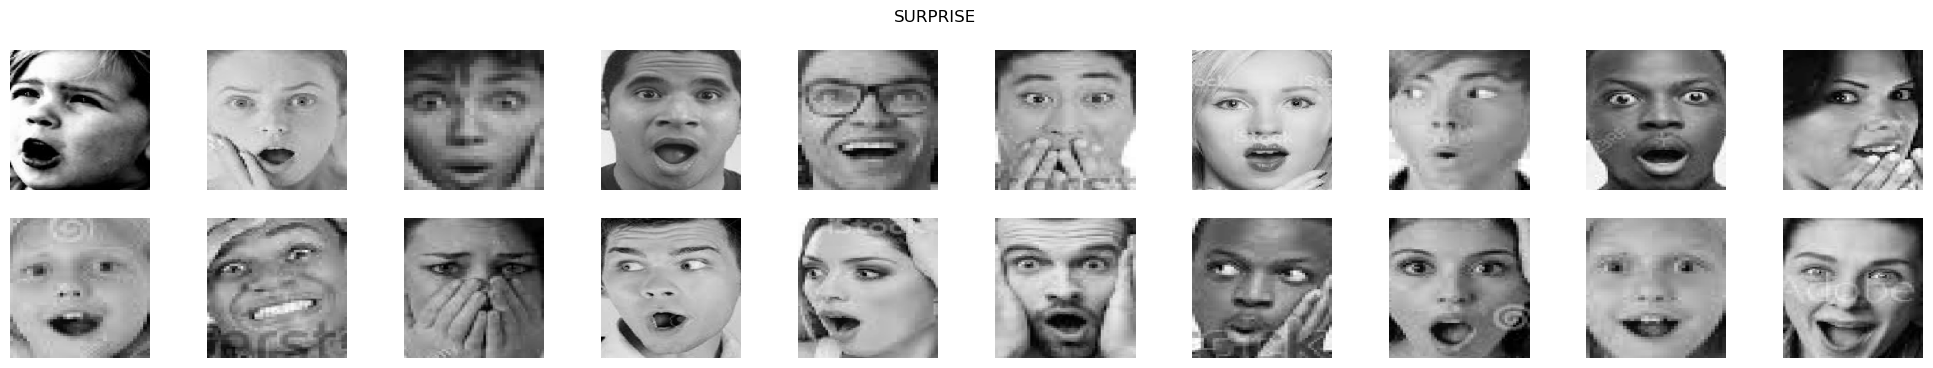

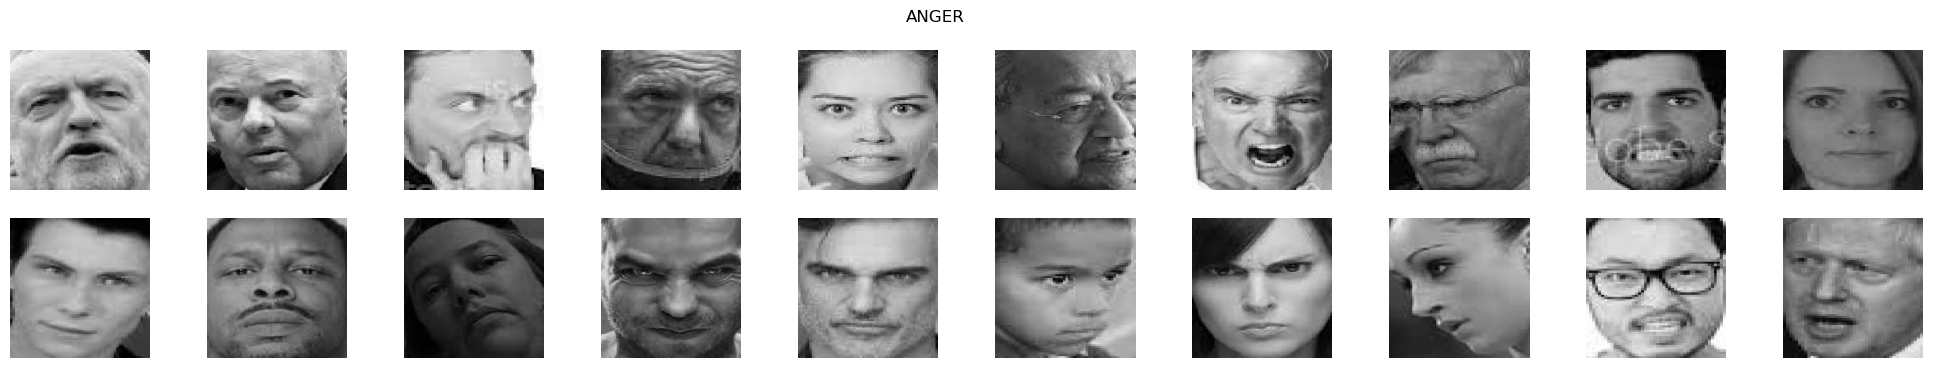

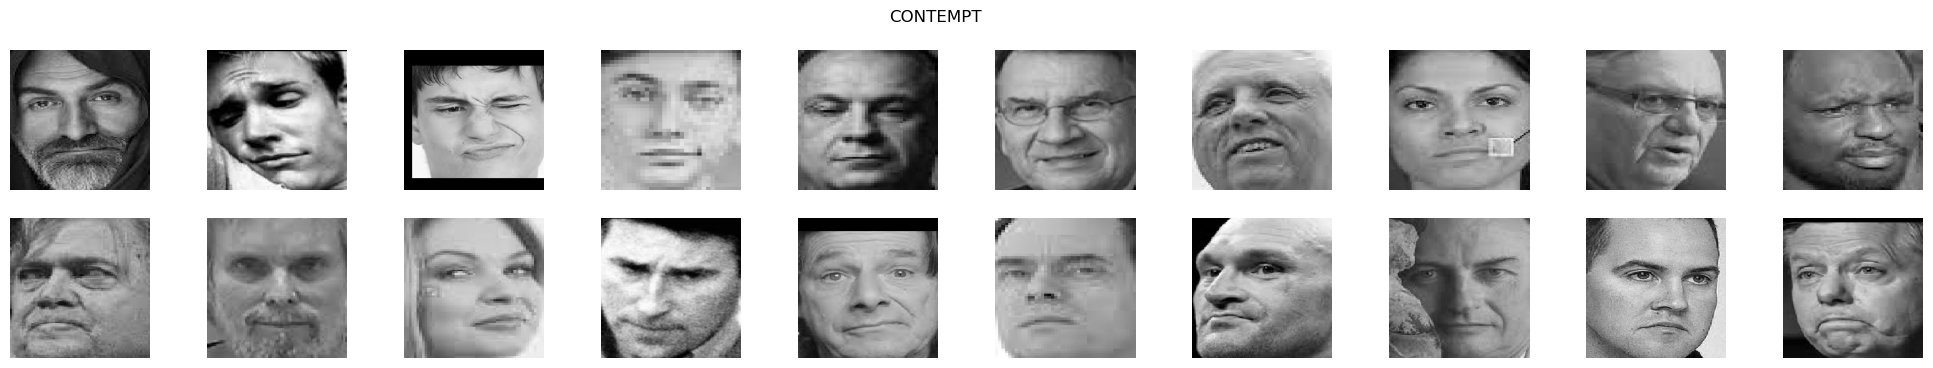

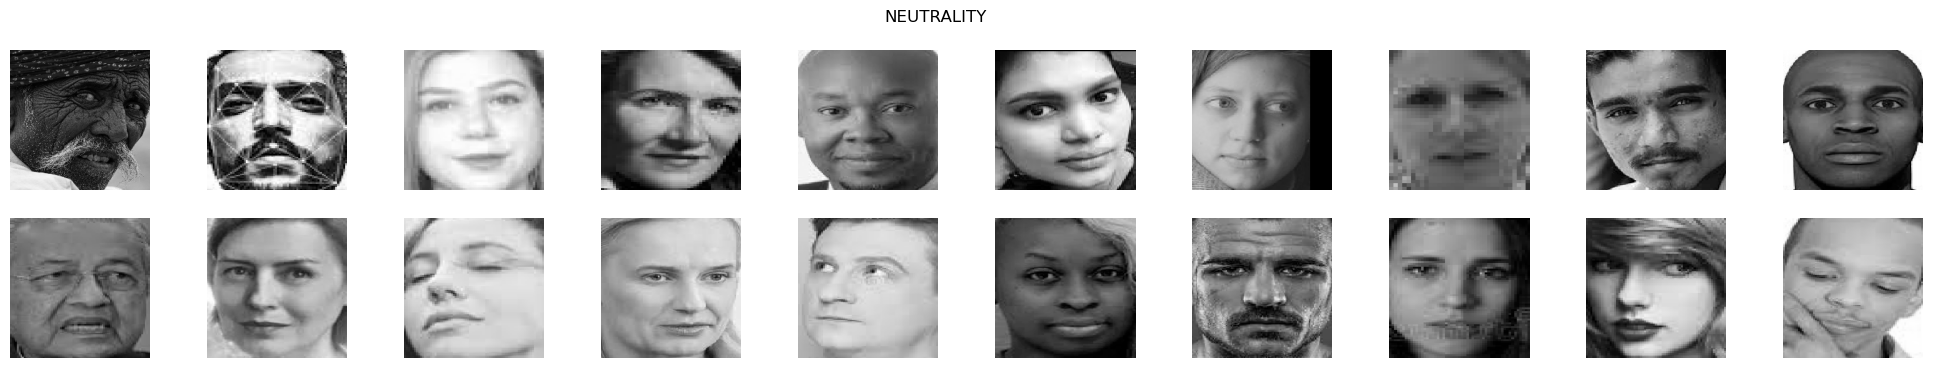

In [6]:
for key in images:
    label = key
    _images = images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(_images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        axs[i].axis("off")
        if i == 19:
            break

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=32)

# Use data augmentation
ZOOM = (0.0, -0.2)
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
        # , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=ZOOM, width_factor=ZOOM)
    ]
)

In [11]:
import pathlib

root = 'dataset_augmented'
pathlib.Path(root).mkdir(exist_ok=True)
for class_name in class_names:
  pathlib.Path(f'{root}/{class_name}').mkdir(exist_ok=True)

imax  = max(nlabels)
lefts = [imax - qty for qty in nlabels]

In [12]:
for label in images:
    left = lefts[label]
    while left:
        lst = images[label]
        image = tf.expand_dims(random.choice(lst),0)
        augmented_image = data_augmentation(image)
        formatted_image = augmented_image[0].numpy()
        tf.keras.utils.save_img(f'{root}/{class_names[label]}/augmented_{left}.png', formatted_image)
        left = left - 1